## Preparations

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="tab10")

In [21]:
import scipy.stats as st

## Load Dataset

In [22]:
df = pd.read_csv('water_potability.csv', header=None)
df.columns = ["id", "pH", "Hardness", "Solids", "Chloramines", "Sulfate", "Conductivity", "OrganicCarbon", "Trihalomethanes", "Turbidity", "Potability"]
df.columns = [s.lower() for s in df.columns]
df.head()

,id,ph,hardness,solids,chloramines,sulfate,conductivity,organiccarbon,trihalomethanes,turbidity,potability
0,1,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
1,2,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
2,3,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
3,4,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
4,5,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


## Descriptive Statistics - 1

Pada bagian ini, perhatikan bahwa std dan variance dihitung dari library Pandas. Maka, rumusnya adalah rumus std dan varians untuk populasi. Jika ingin menghitung std/varians sampel, harus dilakukan terlebih dahulu perkalian n/(n-1) pada varians. Namun, karena n = 2010, sehingga n/(n-1) mendekati 1, hasil dari library Pandas sudah dapat mewakili std/varians sampel. 

Dengan kata lain,
$$ \sigma \approx s $$
dan rasio n/(n-1) tidak lagi signifikan.

In [23]:
df.potability = df.potability.astype('object') # Karena kategorikal, diganti saja. tujuannya biar tidak muncul waktu di-describe
df.dtypes

id                   int64
ph                 float64
hardness           float64
solids             float64
chloramines        float64
sulfate            float64
conductivity       float64
organiccarbon      float64
trihalomethanes    float64
turbidity          float64
potability          object
dtype: object

In [24]:
df_desc = df.describe()[df.columns[1:-1]].T
df_desc["range"] = df_desc["max"] - df_desc["min"]
df_desc["IQR"] = df_desc["75%"] - df_desc["25%"]
df_desc["var"] = df_desc.apply(lambda x: df[x.name].var(), axis=1)
df_desc["skew"] = df_desc.apply(lambda x: df[x.name].skew(), axis=1)
df_desc["kurtosis"] = df_desc.apply(lambda x: df[x.name].kurtosis(), axis=1)
df_desc["median"] = df_desc.apply(lambda x: df[x.name].median(), axis=1)

In [25]:
df_desc = df_desc[["mean", "median", "std", "var", "range", "min", "max", "25%", "50%", "75%", "IQR", "skew", "kurtosis"]]
df_desc.rename(columns={"25%" : "Q1", "50%" : "Q2", "75%" : "Q3"}, inplace=True)
df_desc

,mean,median,std,var,range,min,max,Q1,Q2,Q3,IQR,skew,kurtosis
ph,7.087193,7.029490,1.572803,2.473709e+00,13.772501,0.227499,14.000000,6.090785,7.029490,8.053006,1.962221,0.048535,0.626904
hardness,195.969209,197.203525,32.643166,1.065576e+03,243.845890,73.492234,317.338124,176.740657,197.203525,216.447589,39.706932,-0.085321,0.525480
solids,21904.673439,20926.882155,8625.397911,7.439749e+07,56167.729801,320.942611,56488.672413,15614.412962,20926.882155,27170.534649,11556.121687,0.591011,0.337320
chloramines,7.134322,7.142014,1.585214,2.512904e+00,11.736129,1.390871,13.127000,6.138326,7.142014,8.109933,1.971607,0.013003,0.549782
sulfate,333.211376,332.214113,41.211111,1.698356e+03,352.030642,129.000000,481.030642,307.626986,332.214113,359.268147,51.641161,-0.045728,0.786854
conductivity,426.476708,423.438372,80.701872,6.512792e+03,551.722883,201.619737,753.342620,366.619219,423.438372,482.209772,115.590553,0.268012,-0.237206
organiccarbon,14.357940,14.323286,3.325770,1.106075e+01,24.806707,2.200000,27.006707,12.122530,14.323286,16.683562,4.561031,-0.020220,0.031018
trihalomethanes,66.400717,66.482041,16.081109,2.586021e+02,115.422987,8.577013,124.000000,55.949993,66.482041,77.294613,21.344620,-0.051383,0.223017
turbidity,3.969497,3.967374,0.780471,6.091350e-01,5.044749,1.450000,6.494749,3.442882,3.967374,4.514663,1.071781,-0.032266,-0.049831


Untuk menghitung modus dari kolom, kami melakukan binning terlebih dahulu pada kolom numerik kontinu. Maka dari itu, modus yang didapat adalah modus dalam bentuk interval. Jika ingin nilai atau intervalnya semakin kecil, perbesar nilai bins. Sebaliknya, jika ingin intervalnya semakin besar, perkecil nilai bins. 

Hati-hati saat mengatur nilai bins. Jika count modus sama seperti kolom lain, maka perhitungan modus dengan metode ini akan sia-sia saja.

In [36]:
bins = 5000
modes = []
for col in df.select_dtypes(include="float64"):
    mode = pd.cut(df[col], bins=bins).mode()[0]
    modes.append(mode)
modes.append(df.potability.mode()[0])

df_mode = pd.DataFrame(index=df.columns[1:])
df_mode["mode"] = modes
df_mode

,mode
ph,"(6.511, 6.513]"
hardness,"(203.365, 203.413]"
solids,"(15969.272, 15980.506]"
chloramines,"(6.39, 6.393]"
sulfate,"(305.79, 305.86]"
conductivity,"(517.426, 517.536]"
organiccarbon,"(14.35, 14.355]"
trihalomethanes,"(63.68, 63.703]"
turbidity,"(3.643, 3.644]"
potability,0


In [40]:
# data lengkap jumlah data dari colName, dengan interval tertentu
colName = "potability"
pd.cut(df[colName], bins=100).value_counts()

(-0.001, 0.01]    1200
(0.99, 1.0]        810
(0.02, 0.03]         0
(0.75, 0.76]         0
(0.73, 0.74]         0
                  ... 
(0.32, 0.33]         0
(0.31, 0.32]         0
(0.3, 0.31]          0
(0.29, 0.3]          0
(0.5, 0.51]          0
Name: potability, Length: 100, dtype: int64

## Histogram, Boxplot Visualization, and Normality Test - 2 & 3

In [ ]:
# fungsi untuk menggambar boxplot
def draw_boxplot(data, color, edge_color, ax, is_vertical=True):
    bplot = ax.boxplot(notch=True,
                        vert=is_vertical, 
                        patch_artist=True,  
                        x=data) 

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bplot[element], color=edge_color)

    for patch in bplot['boxes']:
        patch.set_facecolor(color)    

    ax.set_ylim(0)
    return bplot

# fungsi untuk menggambar histogram dan boxplot
def draw_boxhist(col):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
    f.tight_layout()
    draw_boxplot(df[col], "lightblue", "blue", ax[0])
    sns.histplot(data=df[col], ax=ax[1], kde=True, fill=False)
    plt.show()

In [38]:
# fungsi untuk menentukan kenormalan suatu data

def shap_test(col):
    # menggunakan Shapiro-Wilks Normality Test
    pval = st.shapiro(df[col]).pvalue
    if pval >= 0.05:
        print("Column", col, "is normally distributed")
    else:
        print("Column", col, "is not normally distributed")

def print_skew_kurt(col):
    print("Skew =", df_desc.loc[col]["skew"])
    print("Kurtosis =", df_desc.loc[col]["kurtosis"])

def normal_info(col):
    draw_boxhist(col)
    shap_test(col)
    print_skew_kurt(col)

### PH

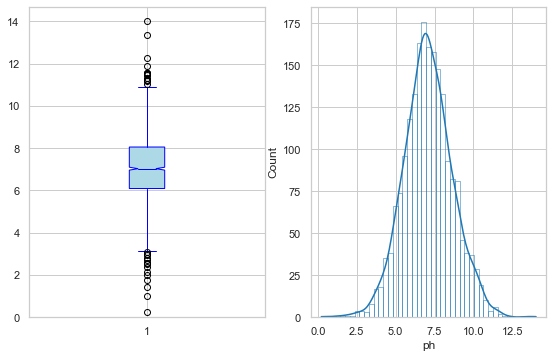

Column ph is not normally distributed
Skew = 0.04853451405270669
Kurtosis = 0.6269041256617065


In [ ]:
normal_info("ph")

Perhatikan bahwa data memiliki bentuk yang leptokurtik. Dapat dilihat pada grafik histogram, data memiliki heavy tails pada kiri dan kanan distribusi. Hal ini didukung dengan grafik boxplot yang menunjukkan banyaknya pencilan pada kiri dan kanan distribusi data (heavy-tailed). 

Meski datanya non-skewed (skew mendekati nol), grafik tetap dikategorikan sebagai non-normal karena tidak mesokurtik.

### Hardness

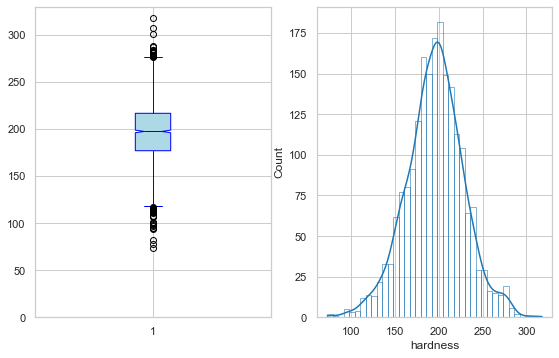

Column hardness is not normally distributed
Skew = -0.08532104172868622
Kurtosis = 0.5254804942991402


In [ ]:
normal_info("hardness")

Data memiliki bentuk yang leptokurtik. Dapat dilihat pada grafik histogram, data memiliki heavy tails pada kiri dan kanan distribusi. Hal ini didukung dengan grafik boxplot yang menunjukkan banyaknya pencilan pada kiri dan kanan distribusi data (heavy-tailed). 

Meski datanya non-skewed (skew mendekati nol), grafik tetap dikategorikan sebagai non-normal karena tidak mesokurtik.

### Solids

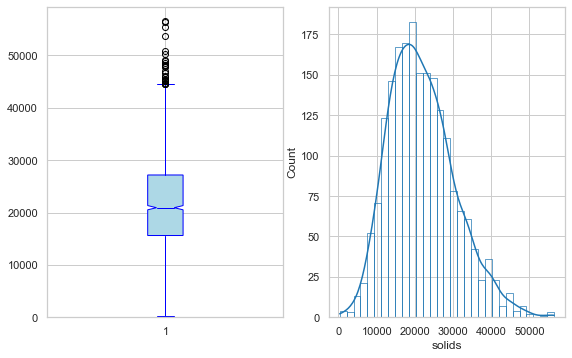

Column solids is not normally distributed
Skew = 0.5910113724580447
Kurtosis = 0.33732026745944976


In [ ]:
normal_info("solids")

Perhatikan bahwa data memiliki skewness yang cukup besar sehingga data dapat dikategorikan sebagai data yang positively skewed. Hal ini dapat dilihat juga pada bagian boxplot, yaitu data memiliki banyak pencilan pada bagian positif. Pada histogram, puncak distribusi data juga mengarah ke kanan. 

Karena data positive-skewed, kolom ini tidak memiliki distribusi yang normal.

### Chloramines

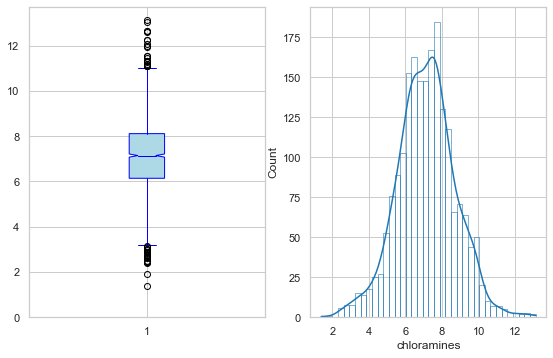

Column chloramines is not normally distributed
Skew = 0.013003497779569528
Kurtosis = 0.5497821097667472


In [ ]:
normal_info("chloramines")

Pada data ini, skew data cukup kecil (skew mendekati nol). Hal ini juga dibuktikan dalam grafik histogram, yaitu puncak distribusi data yang berada di tengah. 

Namun, data ini tidak berdistribusi normal karena heavy-tailed ke kiri dan kanan sehingga berbentuk leptokurutik. Kesimpulan ini dapat dibuktikan dengan nilai kurtosis yang tinggi dan boxplot yang menunjukkan banyak pencilan di kiri dan kanan data (atas dan bawah jika vertikal).

### Sulfate

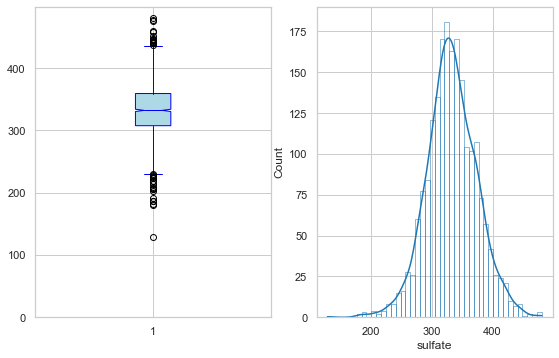

Column sulfate is not normally distributed
Skew = -0.04572780443653543
Kurtosis = 0.7868544988131605


In [ ]:
normal_info("sulfate")

Sama seperti kolom-kolom sebelumnya, jika dilihat dari boxplot, distribusi sampel ini memiliki bentuk yang leptokurtik karena memiliki banyak pencilan di kiri dan kanan. Hal ini juga dibuktikan dengan nilai kurtosis yang cukup jauh dari nol.

Meski datanya non-skewed, distribusi sampel ini dikatakan tidak berdistribusi normal.

### Conductivity

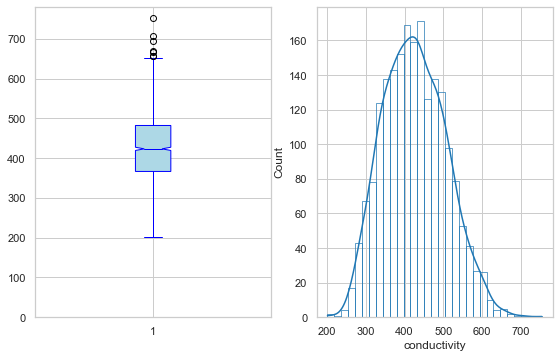

Column conductivity is not normally distributed
Skew = 0.26801233302645316
Kurtosis = -0.23720600574806516


In [ ]:
normal_info("conductivity")

Pada atribut ini, dapat dilihat bahwa data memiliki pencilan ke arah positif sehingga dapat dikatakan data positive-skewed. Data ini juga dapat dikatakan platykurtik karena nilai kurtosis yang cukup jauh dari nol dan negatif. Dapat dilihat juga pada histogram plot, puncaknya cukup lebar (platykurtik).

Karena itu, data dikatakan tidak berdistribusi normal.

### OrganicCarbon

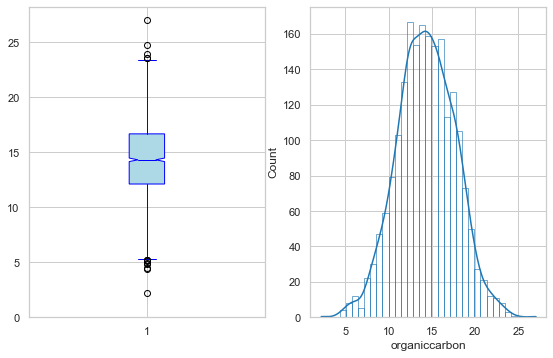

Column organiccarbon is normally distributed
Skew = -0.02021975629181238
Kurtosis = 0.031018388192253


In [ ]:
normal_info("organiccarbon")

Berbeda dengan atribut-atribut sebelumnya, data ini dikategorikan sebagai data yang berdistribusi normal karena memiliki pencilan kiri dan kanan yang relatif lebih sedikit. Kemudian, dapat dilihat pada histogram plot, bentuk kurvanya adalah mesokurtik. Selain itu, nilai skew dan kurtosis mendekati nol.

Berdasarkan informasi yang ada, dapat disimpulkan bahwa atribut ini berdistribusi normal.

### Trihalomethanes

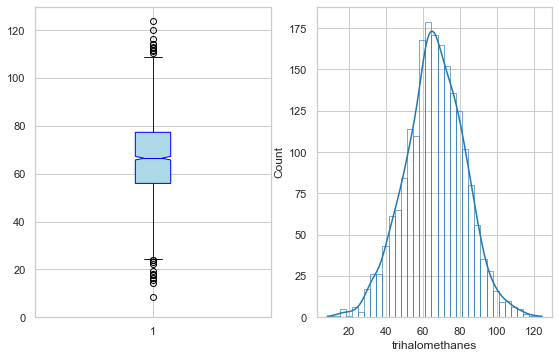

Column trihalomethanes is normally distributed
Skew = -0.05138268451619478
Kurtosis = 0.2230167810639787


In [ ]:
normal_info("trihalomethanes")

Data ini memiliki nilai skew yang mendekati nol, berarti data tidak skewed. Data ini juga tidak terlihat memiliki banyak pencilan menurut histogram plot (bagian kiri dan kanan tidak terlalu landai). 

Maka dari itu, disimpulkan bahwa data ini berdistribusi normal.

### Turbidity

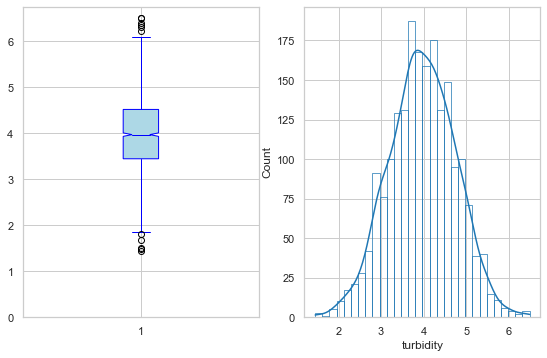

Column turbidity is normally distributed
Skew = -0.03226597968019271
Kurtosis = -0.049830796949249745


In [ ]:
normal_info("turbidity")

Perhatikan bahwa data memiliki pencilan yang tidak cukup banyak. Bagian kiri dan kanan histogram plot tidak terlalu landai. Kemudian, puncak dari histplot juga tidak terlalu lancip dan terlalu lebar. Selain itu, nilai skew dan kurtosis mendekati nol. 

Maka dari itu, disimpulkan bahwa kolom ini berdistribusi normal.

## Hypothesis 1 Test - 4

Pada dataset ini **(khususnya bagian 4A, 4B, dan 4C)**, digunakan t-test untuk melakukan uji hipotesis. T-test digunakan karena **data** yang tertera **merupakan data sampel**, bukan data populasi sehingga sebenarnya **variansi populasi tidak diketahui**. Namun, karena n = 2010 (>= 30) dan dapat dilihat pada bagian sebelumnya bahwa sebagian besar atribut berbentuk *bell-shaped*, maka t-test dapat didekati dengan z-test.

In [ ]:
def compute_t_one(xbar, mu_0, std, n):
    return (xbar - mu_0)/(std/np.sqrt(n))

### Bagian A: Rata-rata pH di atas 7

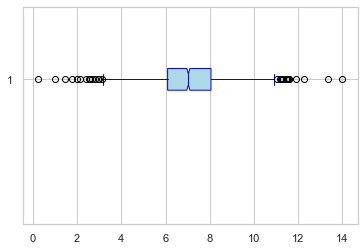

In [ ]:
draw_boxplot(df["ph"], "lightblue", "blue", plt.subplot(), False)
plt.show()

Hipotesis
$$ ^1H_0: \mu = 7 $$
$$ ^2H_1: \mu > 7 $$
dengan tingkat signifikansi
$$ ^3\alpha = 0.05 $$
dan daerah kritis 
$$ ^4t > 1.645; \enspace v = \infty $$ 
dengan
$$ t = \frac{\bar x - \mu_0}{s/\sqrt{n}} $$ 

In [ ]:
mu_0 = 7; n = df.shape[0]

std = df_desc.loc["ph"]["std"]
xbar = df_desc.loc["ph"]["mean"]
tscore = compute_t_one(xbar, mu_0, std, n)

print("5.a) T-score =", tscore)
print("5.b) P-value =", 1 - st.norm.cdf(tscore))

5.a) T-score = 2.485445147379887
5.b) P-value = 0.006469476288896492


**Kesimpulan**: karena p-value < 0.05 dan t > 1.645, hipotesis nol ditolak.

### Bagian B: Rata-rata hardness tidak sama dengan 205

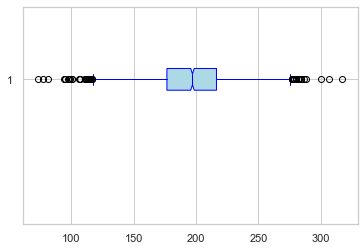

In [ ]:
draw_boxplot(df["hardness"], "lightblue", "blue", plt.subplot(), False)
plt.show()

Hipotesis
$$ ^1H_0: \mu = 205 $$
$$ ^2H_1: \mu \neq 205 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05  $$  
dan daerah kritisnya adalah
$$ ^4t < -1.96 \enspace or \enspace t > 1.96; \enspace v = \infty $$ 
dengan
$$ t = \frac{\bar x - \mu_0}{s/\sqrt{n}} $$ 

In [ ]:
mu_0 = 205; n = df.shape[0]

std = df_desc.loc["hardness"]["std"]
xbar = df_desc.loc["hardness"]["mean"]
tscore = compute_t_one(xbar, mu_0, std, n)

print("5.a) T-score =", tscore)
print("5.b) P-value =", np.round(2 * st.norm.cdf(tscore), 2))

5.a) T-score = -12.403137170010732
5.b) P-value = 0.0


**Kesimpulan**: karena p-value < 0.05 dan t < -1.96, hipotesis nol ditolak. 

### Bagian C: Nilai rata-rata 100 baris pertama kolom Solids bukan 21900

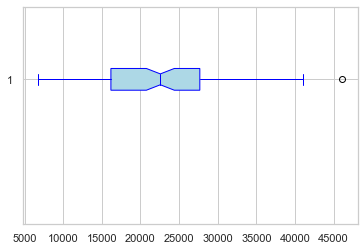

In [ ]:
draw_boxplot(df["solids"].iloc[:100], "lightblue", "blue", plt.subplot(), False)
plt.show()

Hipotesis
$$ ^1H_0: \mu = 21900 $$
$$ ^2H_1: \mu \neq 21900 $$
dengan tingkat signifikan
$$ ^3\alpha = 0.05  $$  
dan daerah kritisnya adalah
$$ ^4t < -1.984 \enspace or \enspace t > 1.984; \enspace v = 99 $$ 
dengan
$$ t = \frac{\bar x - \mu_0}{s/\sqrt{n}} $$ 

In [ ]:
mu_0 = 21900; n = 100

std = df["solids"].iloc[:100].std()
xbar = df["solids"].iloc[:100].mean()
tscore = compute_t_one(xbar, mu_0, std, n)

print("5.a) T-score =", tscore)
print("5.b) P-value =", 2*(1 - st.norm.cdf(tscore)))

5.a) T-score = 0.5636797715721551
5.b) P-value = 0.5729720864655174


**Kesimpulan**: Karena p-value > 0.05 dan -1.984 < t < 1.984, hipotesis nol tidak ditolak. 

### Bagian D: Proporsi nilai Conductivity yang lebih dari 450, adalah tidak sama dengan 10%?

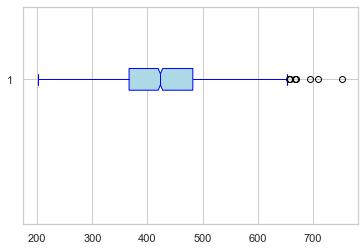

In [ ]:
draw_boxplot(df["conductivity"], "lightblue", "blue", plt.subplot(), False)
plt.show()

Hipotesis
$$ ^1H_0: p_0 = 0.1 $$
$$ ^2H_1: p_0 \neq 0.1 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05  $$  
dan uji statistiknya adalah binomial acak
$$ ^4 X $$ 
serta daerah kritisnya (didekati dengan Z) 
$$ ^4z < -1.96 \enspace or \enspace z > 1.96 $$
P-value binomial yang dihitung adalah
$$ P = 2P(X \ge \enspace 745 \enspace|\enspace p = 0.1) $$

In [ ]:
# Sampel menunjukkan bahwa proporsi yang lebih dari 450 adalah 745
x = sum(df.conductivity.apply(lambda x: 1 if x > 450 else 0)) 
p_0 = 0.1; n = df.shape[0]

mu = n*p_0; std = np.sqrt(mu*(1-p_0))
zscore = ((x - 0.5) - mu)/std # correction factor

# mu = 201, berarti x > np_0(mu)
print("5.a) Z-score =", zscore)
print("5.b) P-value =", 2*(1 - st.norm.cdf(zscore)))

5.a) Z-score = 40.409201153527206
5.b) P-value = 0.0


**Kesimpulan**: Karena p-value < 0.05 dan z > 1.96, hipotesis nol ditolak. 

### Bagian E: Proporsi nilai Trihalomethanes yang kurang dari 40, adalah kurang dari 5%

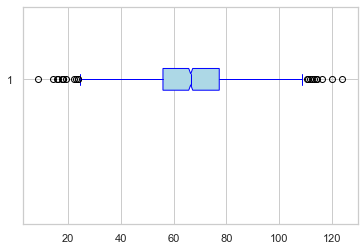

In [ ]:
draw_boxplot(df["trihalomethanes"], "lightblue", "blue", plt.subplot(), False)
plt.show()

Hipotesis
$$ ^1H_0: p_0 = 0.05 $$ 
$$ ^2H_1: p_0 < 0.05 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05  $$  
dan uji statistiknya adalah binomial acak
$$ ^4 X $$ 
serta daerah kritisnya (didekati dengan Z) 
$$ ^4z < -1.645 $$

P-value binomial yang dihitung adalah
$$ P = P(X \le \enspace 106 \enspace | \enspace p = 0.05) $$

In [ ]:
# Sampel menunjukkan bahwa proporsi yang kurang dari 40 adalah 106
x = sum(df.trihalomethanes.apply(lambda x: 1 if x < 40 else 0))
p_0 = 0.05; n = df.shape[0]

mu = n*p_0; std = np.sqrt(mu*(1-p_0))
zscore = ((x + 0.5) - mu)/std # correction factor

print("5.a) Z-score =", zscore)
print("5.b) P-value =", st.norm.cdf(zscore))

5.a) Z-score = 0.6140537909095591
5.b) P-value = 0.7304101088817901


**Kesimpulan**: Karena p-value > 0.05 dan z > -1.645, hipotesis nol tidak ditolak. 

## Hypothesis 2 Test - 5

Helper function for unknown variance but equal

In [ ]:
def compute_t_two(x1, x2, d0, sp, n1, n2):
    numer = (x1 - x2) - d0 
    denom = sp*(np.sqrt(1/n1 + 1/n2))
    return numer/denom

def compute_sp(var1, var2, n1, n2):
    sp_squared = ((var1)*(n1 - 1) + (var2)*(n2-1))/(n1 + n2 - 2)
    return np.sqrt(sp_squared)

Helper function for unknown variance but unequal

In [ ]:
def compute_tAcc_two(x1, x2, d0, var1, var2, n1, n2):
    numer = (x1 - x2) - d0 
    denom = np.sqrt(var1/n1 + var2/n2)
    return numer/denom

def compute_v(var1, var2, n1, n2):
    numer = (var1/n1 + var2/n2)**2
    denom = (var1/n1)**2 /(n1 - 1) + (var2/n2)**2 / (n2-1)
    return numer/denom

### Bagian A: Data kolom Sulfate dibagi 2 sama rata: bagian awal dan bagian akhir kolom. Benarkah rata-rata kedua bagian tersebut sama

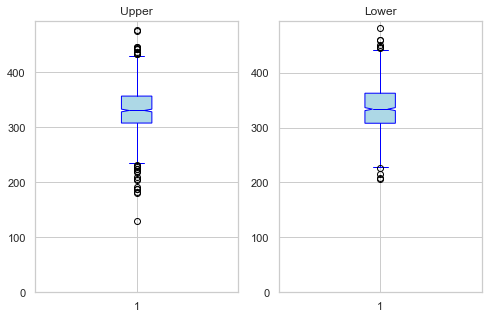

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
draw_boxplot(df.sulfate.iloc[:1005], "lightblue", "blue", ax[0])
draw_boxplot(df.sulfate.iloc[1005:], "lightblue", "blue", ax[1])
ax[0].set_title("Upper")
ax[1].set_title("Lower")
plt.show()

**Remark**: Berdasarkan boxplot, kedua sampel terlihat memiliki variansi yang sama. Maka dari itu, diasumsikan bahwa kedua variansi populasi adalah sama sehingga kami menggunakan metode unknown but equal variances.

Hipotesis
$$ ^1H_0: \mu_1 = \mu_2 $$
$$ ^2H_1: \mu_1 \neq \mu_2 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05 $$  
dan daerah kritisnya adalah
$$ ^4t < -1.96 \enspace or \enspace t > 1.96; \enspace v = \infty $$ 
dengan
$$ t = \frac{(\bar x_1 - \bar x_2) - d_0}{s_p\sqrt{1/n_1 + 1/n_2}} $$ 
dan
$$ s_p^2 = \frac{s_1^2(n_1 -1) + s_2^2(n_2-1)}{n_1+n_2-2} $$

In [ ]:
n = df.shape[0] // 2 
upper = df.sulfate.iloc[:n]
lower = df.sulfate.iloc[n:]

xbar_1 = upper.mean(); xbar_2 = lower.mean()
var_1 = upper.var(); var_2 = lower.var()

sp = compute_sp(var_1, var_2, n, n) 
tscore = compute_t_two(xbar_1, xbar_2, 0, sp, n, n)

print("5.a) T-score =", tscore)
print("5.b) P-value =", 2*st.norm.cdf(tscore))

5.a) T-score = -2.0752690696871983
5.b) P-value = 0.0379616043851286


**Kesimpulan**: Karena p-value < 0.05 dan t < -1.96, hipotesis nol ditolak.

### Bagian B: Data kolom OrganicCarbon dibagi 2 sama rata: bagian awal dan bagian akhir kolom. Benarkah rata-rata bagian awal lebih besar dari pada bagian akhir sebesar 0.15

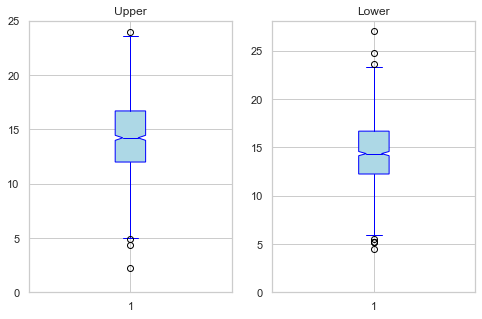

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
draw_boxplot(df.organiccarbon.iloc[:1005], "lightblue", "blue", ax[0])
draw_boxplot(df.organiccarbon.iloc[1005:], "lightblue", "blue", ax[1])
ax[0].set_title("Upper")
ax[1].set_title("Lower")
plt.show()

**Remark**: Berdasarkan boxplot, kedua sampel terlihat memiliki variansi yang sama. Maka dari itu, diasumsikan bahwa kedua variansi populasi adalah sama sehingga kami menggunakan metode unknown but equal variances.

Hipotesis
$$ ^1H_0: \mu_1 - \mu_2  = 0.15 $$
$$ ^2H_1: \mu_1 - \mu_2 > 0.15 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05 $$  
dan daerah kritisnya adalah
$$ ^4t > 1.645; \enspace v = \infty $$ 
dengan
$$ t = \frac{(\bar x_1 - \bar x_2) - d_0}{s_p\sqrt{1/n_1 + 1/n_2}} $$ 
dan
$$ s_p^2 = \frac{s_1^2(n_1 -1) + s_2^2(n_2-1)}{n_1+n_2-2} $$

In [ ]:
n = df.shape[0] // 2 
upper = df.organiccarbon.iloc[:n]
lower = df.organiccarbon.iloc[n:]

xbar_1 = upper.mean(); xbar_2 = lower.mean()
var_1 = upper.var(); var_2 = lower.var()

sp = compute_sp(var_1, var_2, n, n) 
tscore = compute_t_two(xbar_1, xbar_2, 0.15, sp, n, n)

print("5.a) T-score =", tscore)
print("5.b) P-value =", 1 - st.norm.cdf(tscore))

5.a) T-score = -2.413145517798807
5.b) P-value = 0.9920922480912


**Kesimpulan**: Karena p-value > 0.05 dan t < 1.645, hipotesis nol tidak ditolak.

### Bagian C: Rata-rata 100 baris pertama kolom Chloramines sama dengan 100 baris terakhirnya

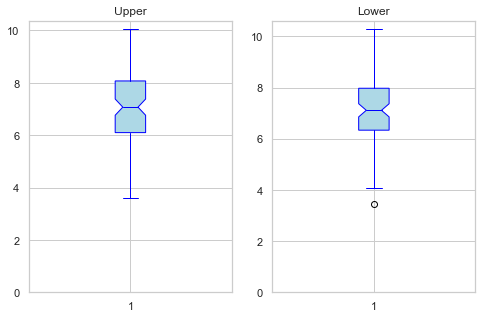

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
draw_boxplot(df.chloramines.iloc[:100], "lightblue", "blue", ax[0])
draw_boxplot(df.chloramines.iloc[df.shape[0] - 100:], "lightblue", "blue", ax[1])
ax[0].set_title("Upper")
ax[1].set_title("Lower")
plt.show()

**Remark**: Berdasarkan boxplot, kedua sampel terlihat memiliki variansi yang sama. Maka dari itu, diasumsikan bahwa kedua variansi populasi adalah sama sehingga kami menggunakan metode unknown but equal variances.

Hipotesis
$$ ^1H_0: \mu_1 = \mu_2 $$
$$ ^2H_1: \mu_1 \neq \mu_2 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05 $$  
dan daerah kritisnya adalah
$$ ^4t < -1.984 \enspace or \enspace t > 1.984; \enspace v = 99 $$ 
dengan
$$ t = \frac{(\bar x_1 - \bar x_2) - d_0}{s_p\sqrt{1/n_1 + 1/n_2}} $$ 
dan
$$ s_p^2 = \frac{s_1^2(n_1 -1) + s_2^2(n_2-1)}{n_1+n_2-2} $$

In [ ]:
n = 100
upper = df.chloramines.iloc[:n]
lower = df.chloramines.iloc[df.shape[0] - n:]

xbar_1 = upper.mean(); xbar_2 = lower.mean()
var_1 = upper.var(); var_2 = lower.var()

sp = compute_sp(var_1, var_2, n, n) 
tscore = compute_t_two(xbar_1, xbar_2, 0.15, sp, n, n)

print("5.a) T-score =", tscore)
print("5.b) P-value =", 2*st.norm.cdf(tscore))

5.a) T-score = -1.4654206021109755
5.b) P-value = 0.1428061999400448


**Kesimpulan**: Karena p-value > 0.05 dan -1.984 < t < 1.984, hipotesis nol tidak ditolak.

### Bagian D: Proporsi nilai bagian awal Turbidity yang lebih dari 4, adalah lebih besar daripada proporsi nilai yang sama di bagian akhir Turbidity

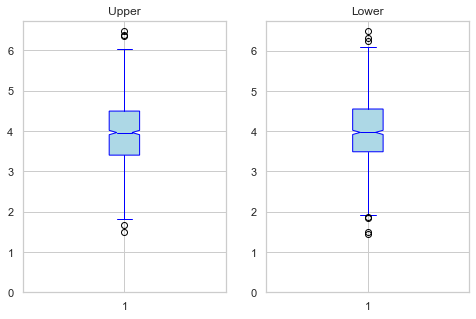

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
draw_boxplot(df.turbidity.iloc[:1005], "lightblue", "blue", ax[0])
draw_boxplot(df.turbidity.iloc[1005:], "lightblue", "blue", ax[1])
ax[0].set_title("Upper")
ax[1].set_title("Lower")
plt.show()

Hipotesis
$$ ^1H_0: p_1 = p_2 $$
$$ ^2H_1: p_1 > p_2 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05  $$  
dan daerah kritisnya adalah
$$ ^4z > 1.645 $$ 
dengan
$$ z = \frac{\hat p_1 - \hat p_2}{\sqrt{\hat p \hat q (1/n_1+1/n_2)}} $$

In [ ]:
n = df.shape[0] // 2
x_1 = sum(df.turbidity.iloc[:n].apply(lambda x: 1 if x > 4 else 0))
x_2 = sum(df.turbidity.iloc[n:].apply(lambda x: 1 if x == 4 else 0))

p_1 = x_1/n; p_2 = x_2/n
p = (x_1 + x_2) / (2*n)
zscore = (p_1 - p_2)/np.sqrt(p*(1-p)*(1/n+1/n))

print("5.a) Z-score =", zscore)
print("5.b) P-value =", 2*(1 - st.norm.cdf(zscore)))

5.a) Z-score = 25.31766679551068
5.b) P-value = 0.0


**Kesimpulan**: Karena p-value < 0.05 dan z > 1.645 , hipotesis nol ditolak.

### Bagian E: Bagian awal kolom Sulfate memiliki variansi yang sama dengan bagian akhirnya

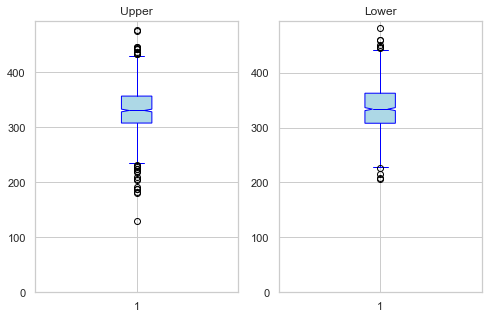

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
draw_boxplot(df.sulfate.iloc[:1005], "lightblue", "blue", ax[0])
draw_boxplot(df.sulfate.iloc[1005:], "lightblue", "blue", ax[1])
ax[0].set_title("Upper")
ax[1].set_title("Lower")
plt.show()

Hipotesis
$$ ^1H_0: \sigma_1^2 = \sigma_2^2 $$
$$ ^2H_1: \sigma_1^2 \neq \sigma_2^2 $$ 
dengan tingkat signifikan
$$ ^3\alpha = 0.05 \newline $$  
dan daerah kritisnya adalah
$$ ^4 f < 0.884 \enspace or f > 1.132 $$ 
dengan
$$ f = \frac{s_1^2}{s_2^2} $$

In [44]:
n = df.shape[0] // 2
var_1 = df.sulfate.iloc[:n].var()
var_2 = df.sulfate.iloc[n:].var()

fscore = var_1/var_2

print("5.a) F-score =", fscore)
print("5.b) P-value = 0.4068") # P = P(F > fscore)

5.a) F-score = 1.0152511043950063
5.b) P-value = 0.4068
0.40522035613151086


**Kesimpulan**: Karena p-value > 0.05 dan 0.884 < f < 1.132, hipotesis nol tidak ditolak.

## Correlation Test - 6

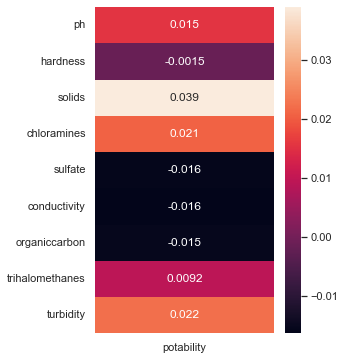

In [ ]:
df["potability"] = df["potability"].astype("int64") # Convert back to numeric value

f, ax = plt.subplots(figsize=(4,6))
sns.heatmap(ax=ax, data=df.corr()[["potability"]][1:-1], annot=True)
plt.show()

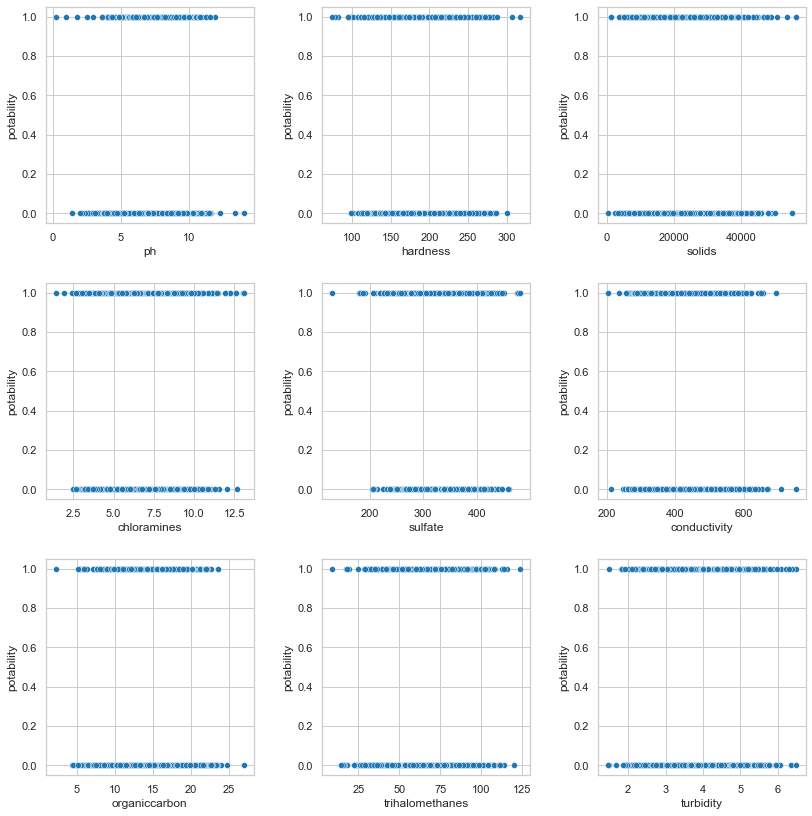

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
f.tight_layout(pad=3)

cols = df.columns[1:-1]
for i in range(3):
    for j in range(3):
        sns.scatterplot(ax=ax[i][j], x=df[cols[i*3+j]], y=df["potability"])

plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

def compute_slope(col):
    X = np.array(df[col]).reshape(-1, 1)
    y = np.array(df["potability"]).reshape(-1, 1)
    r = LinearRegression().fit(X, y)
    return r.coef_[0][0]

compute_slope("ph")

0.004827298207760612